In [1]:
########################################
## import packages
########################################

import datetime
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Dense, Input, Embedding, Dropout, Activation, Reshape
from keras.layers.merge import concatenate, dot
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, SGD
from keras.constraints import Constraint, unit_norm, non_neg
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [4]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


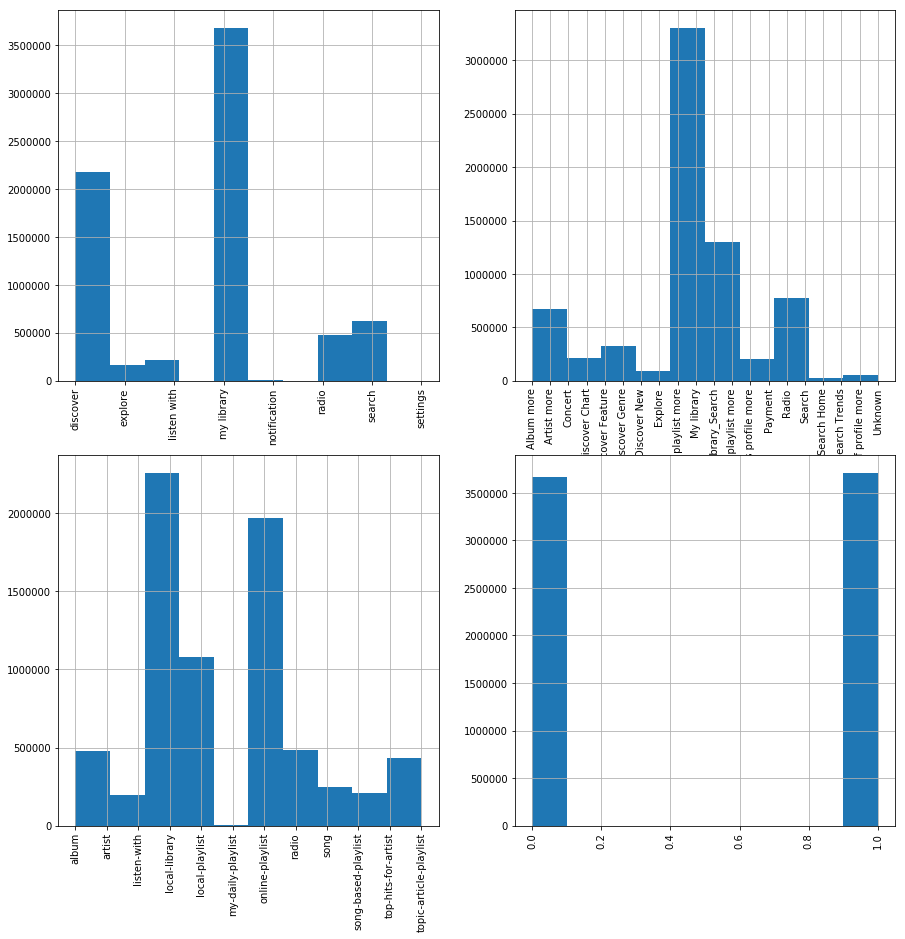

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
train['source_system_tab'].hist(ax=axes[0,0], xrot=90)
train['source_screen_name'].hist(ax=axes[0,1], xrot=90)
train['source_type'].hist(ax=axes[1,0], xrot=90)
train['target'].hist(ax=axes[1,1], xrot=90)
plt.show()

In [3]:
train['source_system_tab'], _ = pd.factorize(train.source_system_tab)

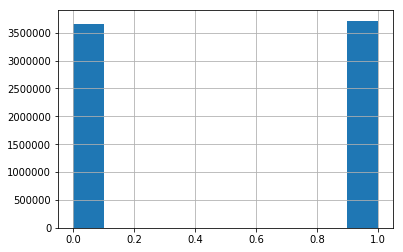

In [11]:
train.target.hist()
plt.show()

In [19]:
songs = pd.read_csv('data/songs.csv')
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


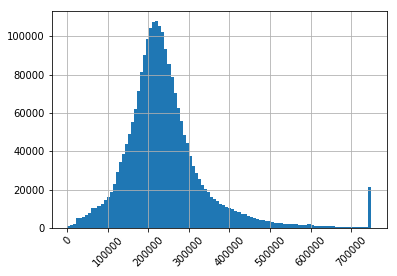

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
songs['song_length_trunc']=songs['song_length'].apply(lambda x: min(x, 750000))
songs['song_length_trunc'].hist(bins=100, xrot=45)
plt.show()

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


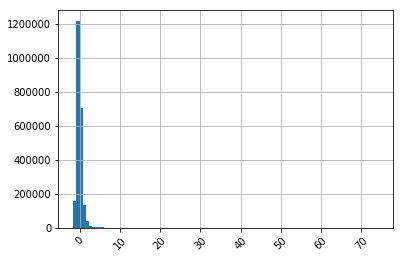

In [10]:
from sklearn import preprocessing
songs['song_length_scaled'] = preprocessing.scale(songs.song_length)
songs['song_length_scaled'].hist(bins=100, xrot=45)
plt.show()

In [4]:
users = pd.read_csv('data/members.csv')
users.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


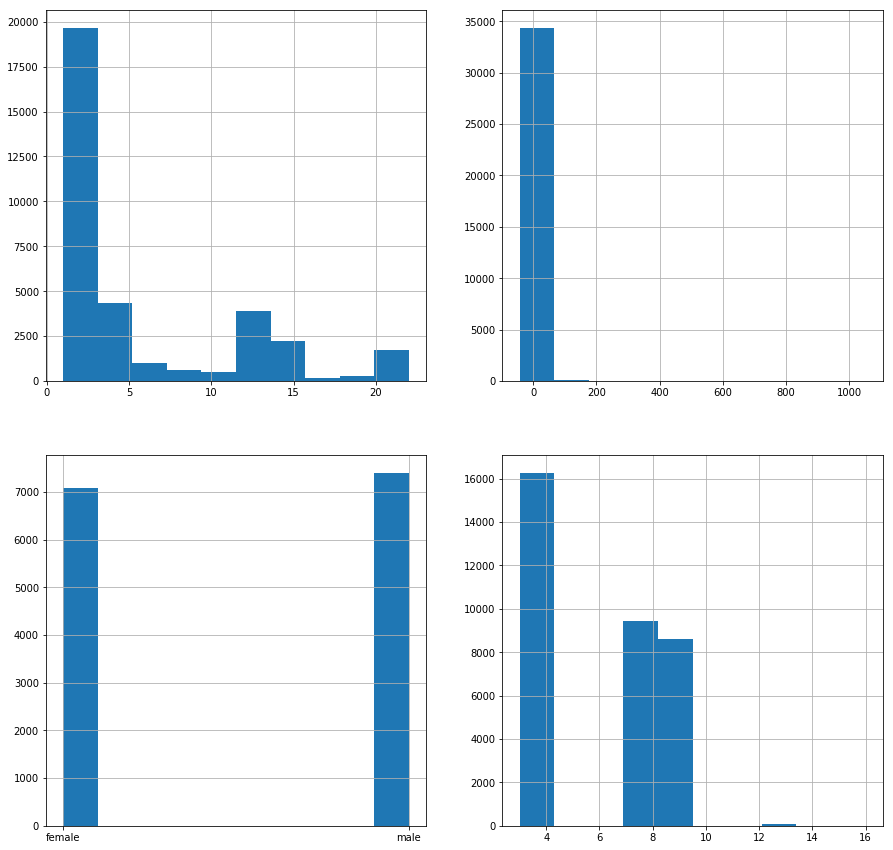

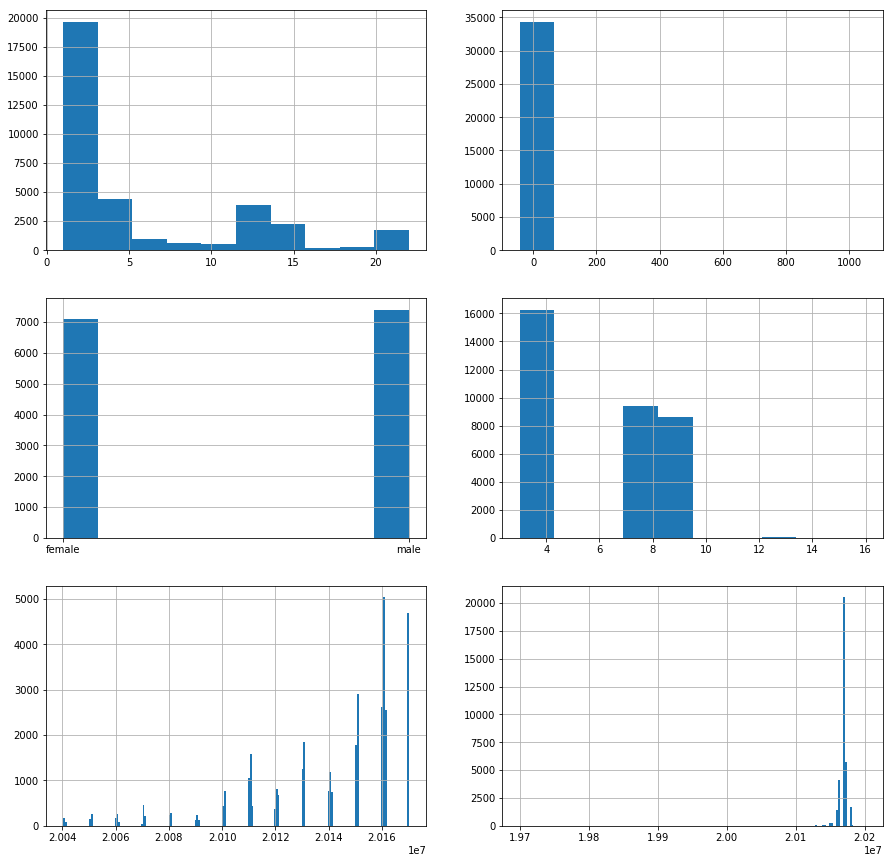

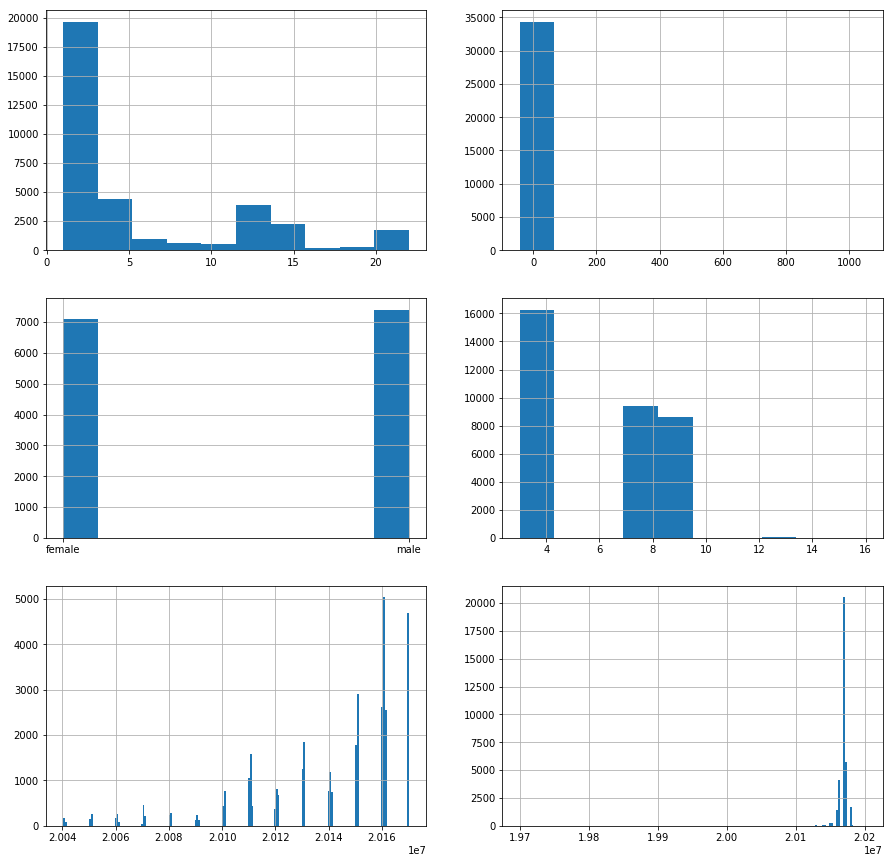

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
users.city.hist(ax=axes[0, 0])
users.bd.hist(ax=axes[0, 1])
users.gender.hist(ax=axes[1, 0])
users.registered_via.hist(ax=axes[1, 1])
users.registration_init_time.hist(bins=200, ax=axes[2, 0])
users.expiration_date.hist(bins=200, ax=axes[2, 1])
plt.show()

In [5]:
song_extra = pd.read_csv('data/song_extra_info.csv')

In [20]:
res = pd.merge(test, songs, on='song_id', how='left')

In [22]:
res[res.genre_ids == ]

,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,language


In [24]:
users.bd.describe()

count    34403.000000
mean        12.280935
std         18.170251
min        -43.000000
25%          0.000000
50%          0.000000
75%         25.000000
max       1051.000000
Name: bd, dtype: float64

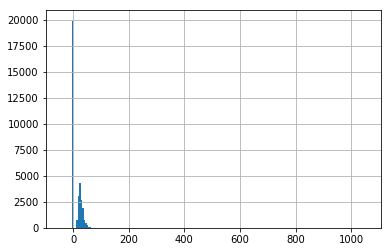

In [6]:
users.bd.hist(bins=200)
plt.show()

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pos = users.bd[users.bd > 0]
scaler.fit(pos.values.reshape(-1, 1))
users['bd_new'] = users.bd.apply(lambda x: scaler.transform(x)[0][0] if x > 0 else 0)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [32]:
users['bd_invalid'] = users.bd <= 0
users['bd_invalid'].astype(int)
sum(users['bd_invalid'])

19934

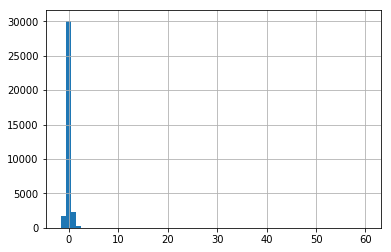

count    3.440300e+04
mean     3.046393e-17
std      6.485260e-01
min     -1.596536e+00
25%     -1.209030e-02
50%      0.000000e+00
75%      0.000000e+00
max      5.996210e+01
Name: bd_new, dtype: float64

In [54]:
users['bd_new'].hist(bins=60)
plt.show()
users['bd_new'].describe()